In [133]:
from pathlib import Path
import csv
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import numpy
from pykml import parser 

In [134]:
#folder in which the Safecast log and FlightAware files are stored and where the output is stored
path_output="/Users/Cosmic-On-Air/Paris-Santiago/3122" 

# File inputs
file_log = Path(path_output+'31221006.log')
file_kml = path_output+'FlightAware_AFR406_LFPG_SCEL_20231006.kml'

#parses through the kml FlightAware file using pykml
with open(file_kml) as f:
    doc = parser.parse(f).getroot()

#Set to "Yes" when GPS data is available and accurate, else set to "No"
control="No"

In [135]:

#Function to read and parse the log file (file) and sort the data into a variety of categories including:
#device ID, datetime, count rate  and GPS coordinates
#It stores it in the variables data and data_gps..

def read_logfile(file):
    data = []

    with open(str(file)) as c:
        buffer = csv.reader(c)
        for row in buffer:
            if row[0].startswith('#'):
                pass
            else:
                tmp_data = {}
                tmp_data['device_id'] = row[1][1:]
                tmp_data['datetim'] = datetime.datetime.strptime(row[2],'%Y-%m-%dT%H:%M:%SZ')
                tmp_data['cnt_1mn'] = int(row[3])
                tmp_data['cnt_5sc'] = int(row[4])
                tmp_data['cnt_tot'] = int(row[5])
                tmp_data['cnt_val'] = row[6]
                tmp_data['gps_lat'] = float(row[7][0:2]) + float(row[7][2:])/60
                if row[8] == 'S':
                    tmp_data['gps_lat'] *= -1
                tmp_data['gps_lon'] = float(row[9][0:3]) + float(row[9][3:])/60
                if row[10] == 'W':
                    tmp_data['gps_lon'] *= -1
                tmp_data['gps_alt'] = float(row[11])
                tmp_data['gps_val'] = row[12]
                tmp_data['gps_hdop'] = float(row[13])
                tmp_data['gps_extra'] = row[14] 
                data.append(tmp_data)

    data_gps = [d for d in data if d['gps_val'] == 'A']
    return data_gps, data

In [136]:
#Function to read and parse the KML file (filename_kml) containing flight data. 
#It extracts timestamps (kml_time) and corresponding coordinates (kml_place) from the KML file using XML parsing.
def read_kml(filename_kml):
    kml_time = []
    for e in doc.Document.Placemark[2].findall(".//{http://www.opengis.net/kml/2.2}when"):
        kml_time.append(datetime.datetime.strptime(e.text,"%Y-%m-%dT%H:%M:%SZ"))

    kml_place = []
    for e in doc.Document.Placemark[2].findall(".//{http://www.google.com/kml/ext/2.2}coord"):
        kml_place.append(dict(zip(['lon', 'lat', 'alt'],e.text.split(' '))))

    return kml_time,kml_place

In [137]:
#Function to interpolate flight coordinates (y0) based on timestamps (x0) from KML and timestamps (x1) from the log file data. 
#It returns interpolated values (y1) for latitude, longitude, and altitude.
def interpol(y0, x0, x1):
    y1 = []
    ix0 = 0
    for i in range(len(x1)):
        if x1[i] < x0[0]:
            y1.append(y0[0])
        elif x1[i] > x0[-1]:
            y1.append(y0[-1])
        else:
            while x0[ix0] < x1[i]:
                ix0 += 1 
            y1.append((y0[ix0]-y0[ix0-1])/((x0[ix0]-x0[ix0-1]).total_seconds())*((x1[i]-x0[ix0-1]).total_seconds())+y0[ix0-1])
    return y1

In [138]:
def write_newlog(new_file, data, kml_time, interp_lon, interp_lat, interp_alt):
# create a new log file with the interpolated and raw data coordinates together
    
    with open(str(new_file), 'w') as f:
        f.write("# NEW LOG\n")
        f.write("# format=1.3.6nano\n")
        f.write("# deadtime=on\n")

# Checks if the timestamp (item['datetim']) falls within the range of consecutive timestamps covered by the KML data (kml_time). 
# If not, it uses interpolated coordinates (interp_lat, interp_lon, interp_alt). 
# If yes, it uses the original GPS coordinates (item['gps_lat'], item['gps_lon'], item['gps_alt'])
        
        for i in range(len(data)):

            item = data[i] 
            if item['datetim'] > kml_time[0] and item['datetim'] < kml_time[-1]:
                cur_lat = interp_lat[i]
                cur_lon = interp_lon[i]
                cur_alt = interp_alt[i]
                cur_gps_val = "A"
            else:
                cur_lat = item['gps_lat']
                cur_lon = item['gps_lon']
                cur_alt = item['gps_alt']
                cur_gps_val = item['gps_val']

#Determines the direction (N, S, E, W) and formats latitude and longitude into degrees and minutes for writing to the log file.
            if cur_lat > 0:
                cur_gps_lat_dir = "N"
            else: 
                cur_gps_lat_dir = "S"
                
            if cur_lon > 0:
                cur_gps_lon_dir = "E"
            else: 
                cur_gps_lon_dir = "W"
            
#Formats the data into a comma-separated string and writes it to the new log file. 
#The data includes device ID, timestamp, radiation counts, GPS coordinates, altitude, GPS quality, and additional GPS information (gps_extra).
            f.write(",".join(["$BNRDD", 
                            "1{}".format(item['device_id']),
                            item['datetim'].strftime("%Y-%m-%dT%H:%M:%SZ"),
                            "{}".format(item['cnt_1mn']),
                            "{}".format(item['cnt_5sc']),
                            "{}".format(item['cnt_tot']),
                            item['cnt_val'],
                            "{:02f}".format(cur_lat),
                            cur_gps_lat_dir,
                            "{:03f}".format(cur_lon),
                            cur_gps_lon_dir,
                            "{:.2f}".format(cur_alt),
                            cur_gps_val,
                            "{}".format(int(item['gps_hdop'])),
                            str(item['gps_extra'])])+"\n")

In [139]:
def plot_latitude(control, data, interp_lat):
    if control == "Yes":
        lat = [d['gps_lat'] for d in (data)]
    else:
       lat = interp_lat

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.scatter(lat, [d['cnt_1mn'] for d in data], marker = '.', label="CPS-1min", color = '#FF7518')
    plt.xlabel('Latitude (Degrees)', fontsize=14)
    plt.ylabel('Radiation Rate (Counts per Minute)', fontsize=14)
    plt.title('2023-10-06 / PARIS-SANTIAGO / DETECTOR 3122 - Latitude vs Radiation Rate', fontsize=14)
    plt.ylim(10,1500)
    if lat[0] > lat[-1]:
        plt.gca().invert_xaxis()


In [140]:
def plot_longitude(control, data, interp_lon):
    if control == "Yes":
        lon = [d['gps_lon'] for d in (data)]
    else:
       lon = interp_lon

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.scatter(lon, [d['cnt_1mn'] for d in data], marker = '.', label="CPS-1min", color = '#FF7518')
    plt.xlabel('Longitude (Degrees)', fontsize=14)
    plt.ylabel('Radiation Rate (Counts per Minute)', fontsize=14)
    plt.title('2023-10-06 / PARIS-SANTIAGO / DETECTOR 3122 - Longitude vs Radiation Rate', fontsize=14)
    plt.ylim((10,1500)) 
    if lon[0] > lon[-1]:
        plt.gca().invert_xaxis()

In [141]:
def plot_altitude(control, data, interp_alt):
    if control == "Yes":
        alt = [d['gps_alt'] for d in (data)]
    else:
       alt = interp_alt 
       
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.scatter(alt, [d['cnt_1mn'] for d in data], marker = '.',label="CPS-1min", color = '#FF7518')
    plt.xlabel('Altitude (Meters)', fontsize=14)
    plt.ylabel('Radiation Rate (Counts per Minute)', fontsize=14)
    plt.title('2023-10-06 / PARIS-SANTIAGO / DETECTOR 3122- Altitude vs Radiation Rate', fontsize=14)
    plt.ylim(0.01,)
    plt.xlim(1000,) #to avoid any radiation detected before take-off

In [142]:
#Plots a world map with flight path and colour maps various dose rates.
def plot_world(interp_lon,interp_lat,data, the_max):
    txt =  " Dosis max: {:.2f} Counts Per Minute (CPM)"
    extended_title = txt.format(the_max)

    fig = plt.figure(figsize=(25, 15))
    ax1 = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax1.stock_img()

#to ensure that any dose > 95% of the max dose does not skew the colour map
    d_tmp = [d['cnt_1mn'] for d in data]
    for i in range(len(d_tmp)): 
        if d_tmp[i] >= the_max*0.95:
            d_tmp[i]=the_max*0.95
            
    p1=plt.scatter(interp_lon, interp_lat, c=d_tmp, cmap='rainbow')
    plt.xlim(-180, 180)
    plt.ylim(-90,90)
    plt.title('2023-10-06 / PARIS-SANTIAGO / DETECTOR 3122/'+ extended_title, fontsize=24)

    #creating a legend for the colour-map 
    cbar = plt.colorbar(p1, ax=ax1, orientation='vertical')
    cbar.set_label('Dose Rate (CPM)', labelpad=30, fontsize=22)
    cbar_ticks = [0, the_max  * 0.2, the_max  * 0.4, the_max  * 0.6, the_max  * 0.8, the_max  * 0.95]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in cbar_ticks])
    cbar.ax.tick_params(labelsize=20)



870


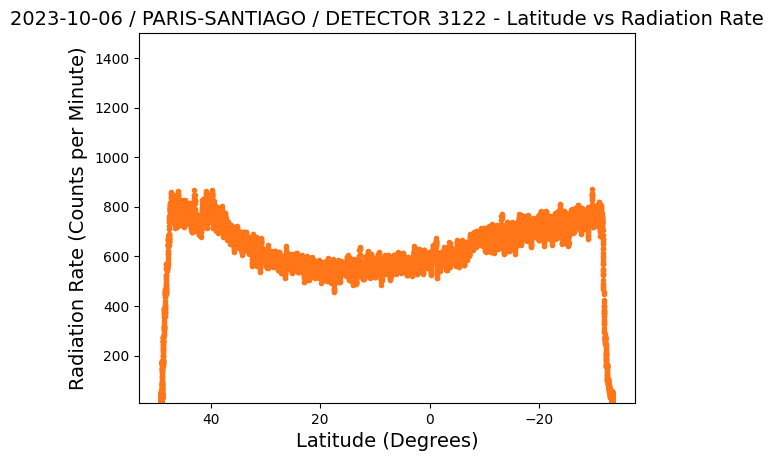

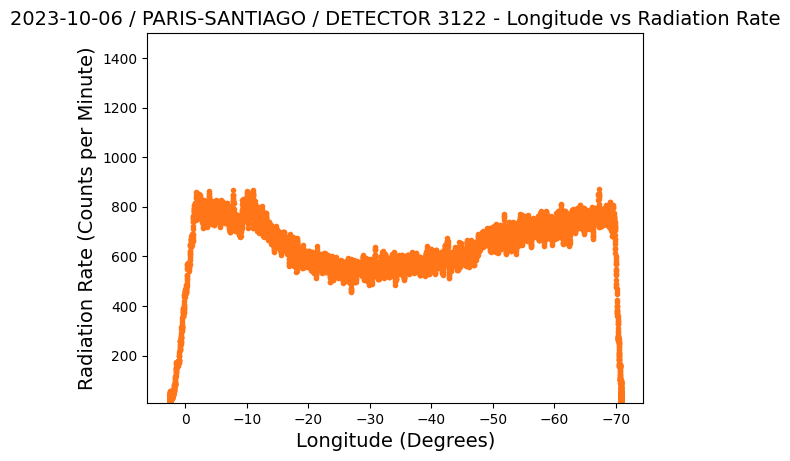

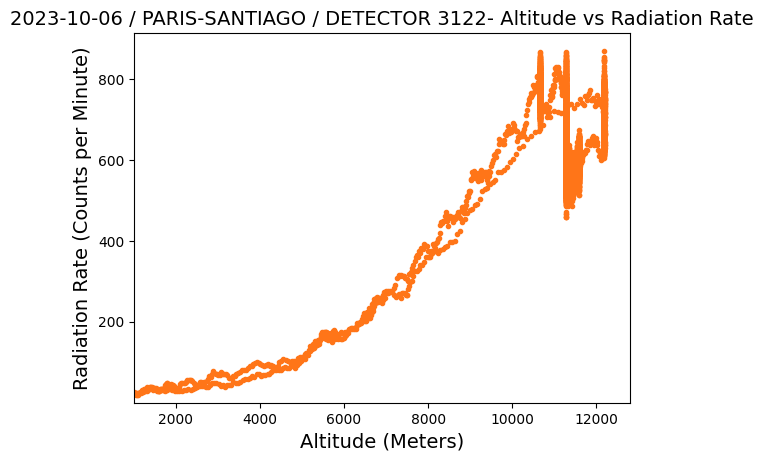

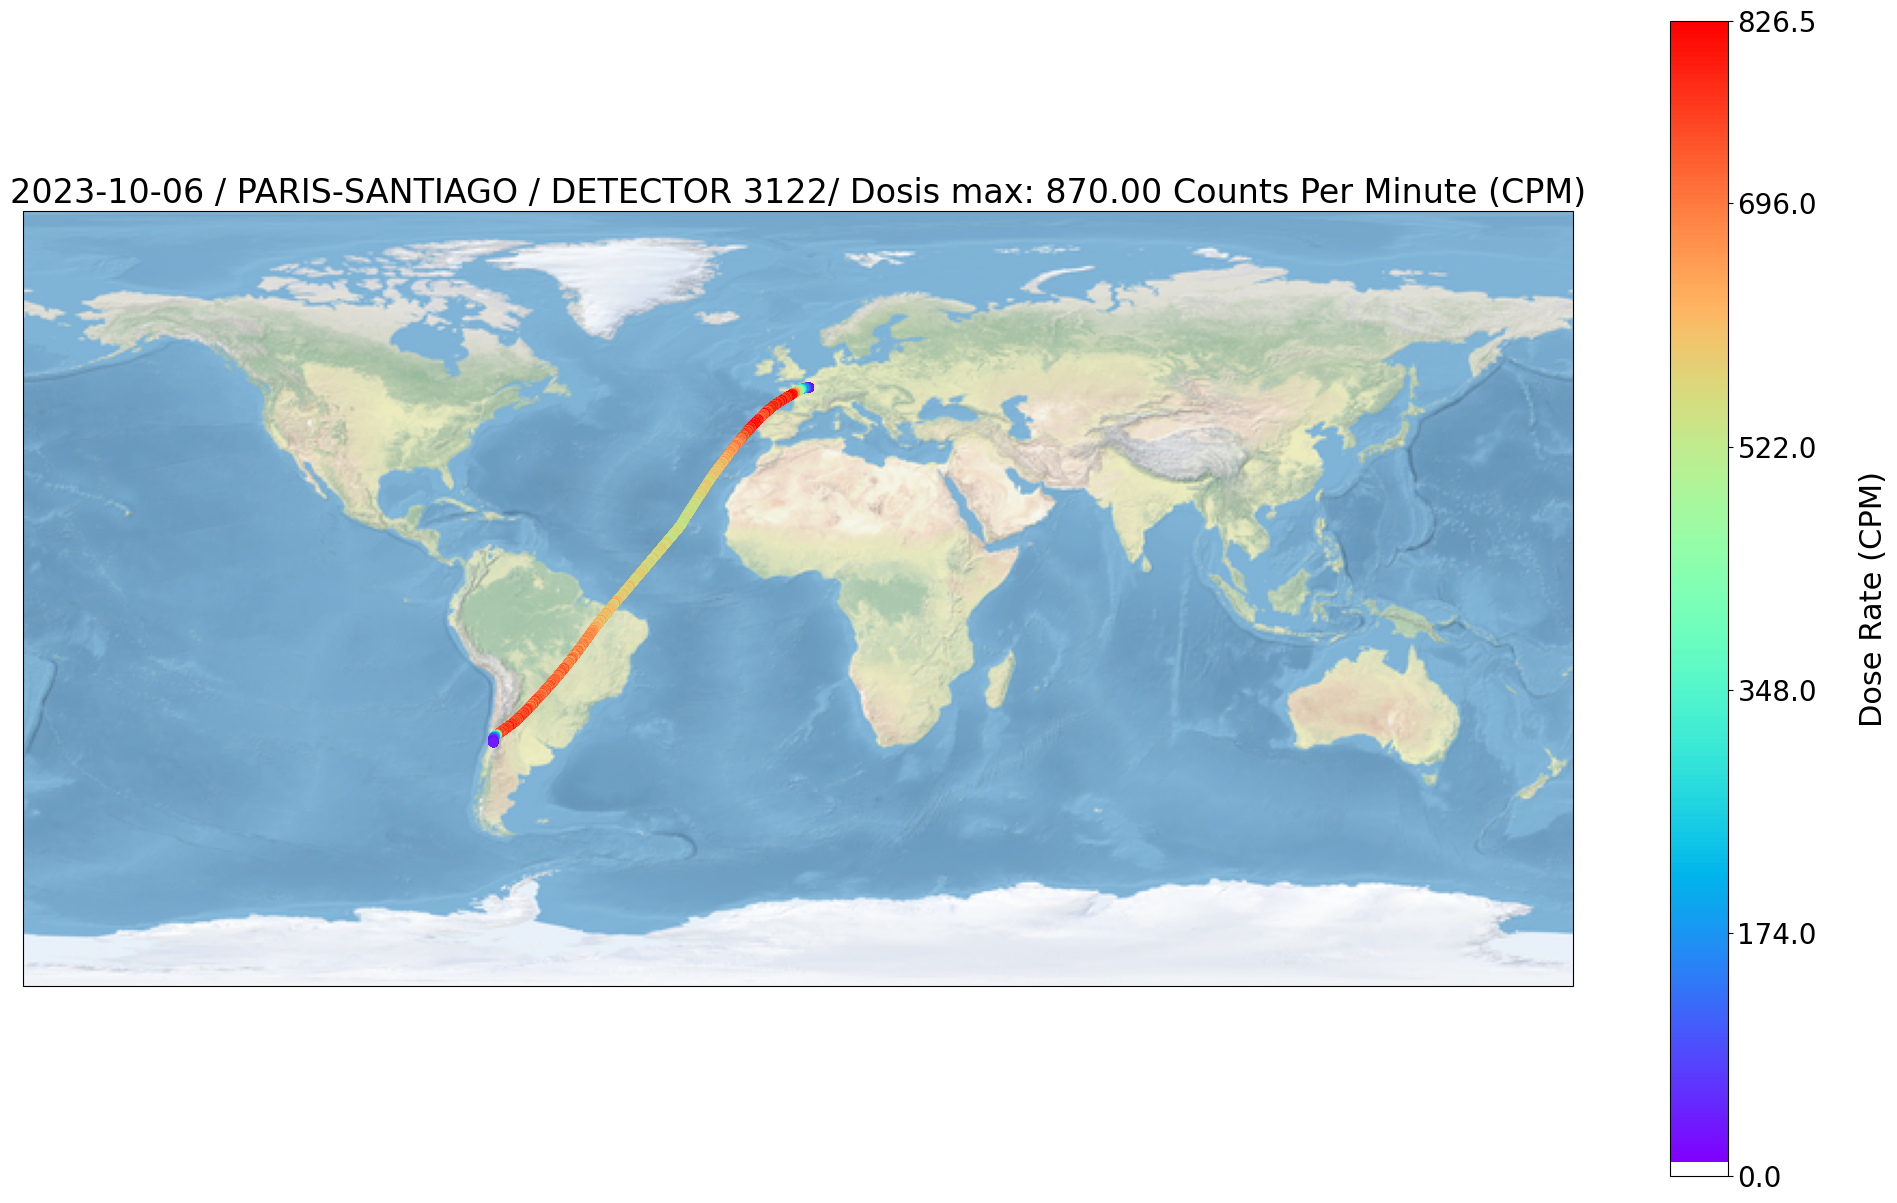

In [143]:
data_gps,data = read_logfile(file_log)

#This line extracts the date (year, month, and day) from the first entry in data_gps and stores it in dt0_gps
dt0_gps = datetime.datetime(data_gps[0]['datetim'].year, data_gps[0]['datetim'].month, data_gps[0]['datetim'].day)

#This reads the FlightAware file and generates kml_time and kml_place variables for time and coordinate data respectively
kml_time,kml_place = read_kml(filename_kml=file_kml)

#Calls the interpol function to estimate the longitude (interp_lon), latitude (interp_lat), and altitude (interp_alt)
interp_lon = interpol([float(d['lon']) for d in kml_place], kml_time, [d['datetim'] for d in data])
interp_lat = interpol([float(d['lat']) for d in kml_place], kml_time, [d['datetim'] for d in data])
interp_alt = interpol([float(d['alt']) for d in kml_place], kml_time, [d['datetim'] for d in data])

# Calculate the maximum value of radiation counts per minute
the_max = max(d['cnt_1mn'] for d in data)
print(the_max)

#calls the plot_latitude function 
plot_latitude(control, data, interp_lat)

#calls the plot_longitude function
plot_longitude(control, data, interp_lon)

#calls the plot_altitude function
plot_altitude(control, data, interp_alt)
              
#calls the plot_world function
plot_world(interp_lon,interp_lat,data, the_max)

#creates a new .log file to store all the plotted and adjusted parameters
new_file = file_log.parent / "{}-new.log".format(file_log.stem)
write_newlog(new_file, data, kml_time, interp_lon, interp_lat, interp_alt)
